# Homework 7 (50 points)

In this Homework, we will try to classify observations of space to be either stars, galaxies or quasars based on the RD14 from the Sloan Digital Sky Survey  (SDSS). The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

http://www.sdss.org/
![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.


In this homework we will train several classifier to predict the class of a celestial object based on the observations (features). We will practice data prep, dimensionality reduction, model design and training, model comparison, and feature importance selection.

### Importing Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


import sklearn.decomposition
from collections import Counter

## 1) Data Preparation (20 points)

We follow the following steps:
* read (1 point)
* clean (3 points)
* correlate (4 points)
* explore, spread of values (3 points)
* dimensionality reduction (9 points)

### 1.1 Data read
Read the pandas fata frame from the csv file "Skyserver_SQL2_27_2018.csv" and skip the first row.

**Task: read (1 point)**

Save a copy of the data frame just in case.

In [49]:
# answer
sdss_df = pd.read_csv("Skyserver_SQL2_27_2018.csv")
sdss_df_bk=sdss_df #back up the data

**Description of the data fields**

* objid = Object Identifier, self explanatory.
* ra = J2000 Right Ascension (r-band). Angular that is measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question.   https://en.wikipedia.org/wiki/Right_ascension
* dec = J2000 Declination (r-band). Angle that is measured north or south of the celestial equator, along the hour circle passing through the point in question. https://en.wikipedia.org/wiki/Declination



The Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further Information: http://astroweb.case.edu/ssm/ASTR620/mags.html 
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit




Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 
* run = Run Number, which identifies the specific scan. 
* rereun = Rerun Number, which specifies how the image was processed.
* camcol = Camera column, a number from 1 to 6, identifying the scanline within the run.
* field = Field number, which typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object): The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift: In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

* plate = plate number: Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

* mjd = MJD of observation, **Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.
* fiberid = fiber ID. The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### 1.2 Data Cleaning 

Basic stats about our dataset. 

**Task: Provide basic infor for the pandas dataframe head (0.5 point)**

In [50]:
# head
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


**Task: Find the data types of the database (floats, string, etc etc) using the ``info()`` function (0.5 point).**

In [51]:
# information
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Are there any obvious feature (or element of the dataframe) that should not impact our prediction?
 
**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.
The features **run**, **rerun**, **camcol** and **field** are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

**Task: Drop these columns in the pandas dataframe. (1 point)**

In [52]:

# answer
sdss_df.drop(columns =['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field'],inplace=True)


Find our how many examples there are, how many attributes or feature, and the type of class.

In [53]:
# description
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        10000 non-null  float64
 1   dec       10000 non-null  float64
 2   u         10000 non-null  float64
 3   g         10000 non-null  float64
 4   r         10000 non-null  float64
 5   i         10000 non-null  float64
 6   z         10000 non-null  float64
 7   class     10000 non-null  object 
 8   redshift  10000 non-null  float64
 9   plate     10000 non-null  int64  
 10  mjd       10000 non-null  int64  
 11  fiberid   10000 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 937.6+ KB


**Task: How many objects are in each class? (1 point)**

In [54]:
# Count the elements in each class
Counter(sdss_df['class'])

Counter({'STAR': 4152, 'GALAXY': 4998, 'QSO': 850})

The classes are "GALAXY", "STAR", and "QSO" (quasars). They are defined as strings, but we will convert them to integer in order to apply a loss function on the class labels during training. For this, we use the ``sklearn.preprocessing.LabelEncoder()`` function. We will do so and modify the classes in the dataframe. We should keep a copy of the original data frame to be safe.

In [55]:
sdss_df_save = sdss_df # make a copy of the original data before cleaning it. That works well when the data is small.

# encode class labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df['class'])
sdss_df['class'] = y_encoded
#  GALAXY = 0
# STAR = 1
# QSO = 2

### 1.3 Data correlations
Now let's find the most basic correlations among features. This can be done using the ``corr()`` function to apply on the pandas dataframe. Evaluate this function and comment on what feature is correlated among others. It is convenient to use the matplotlib function ``matshow()`` for clarity. ``seaborn`` is a python module that makes really pretty statistical plots https://seaborn.pydata.org/index.html#. Install it with ``pip`` and import it.

In [69]:
import seaborn as sns

**Task: Plot the correlation matrix that can be called in the pandas dataframe. (2 points)**

Hints:

Use functions of ``heatmap``, add the labels in the axes. The colormap ``coolwarm`` is nice for divergent scales like correlations that vary between -1 and 1. The argument ``center=0`` ensures that the colormap is divergent from zero. Make sure to ignore the label column "class". Remember that dropping a column can be done in place ``sdss_df.drop('class', axis=1)``.

In [57]:
a=sdss_df.drop('class', axis=1).corr() 

<AxesSubplot: >

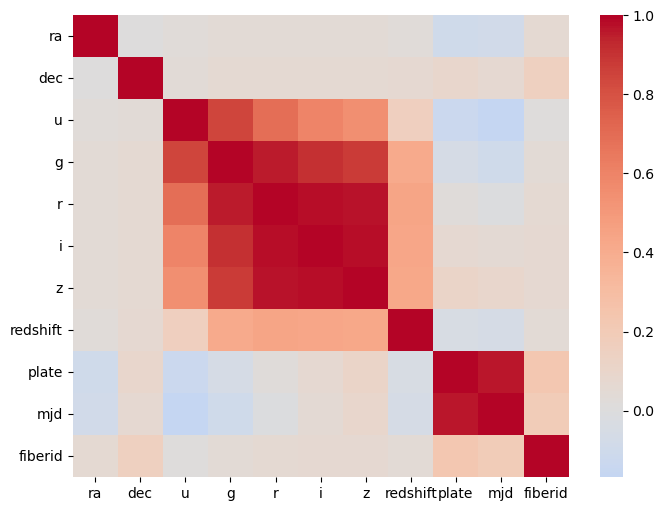

In [58]:
# answer
plt.figure(figsize = (8, 6), dpi = 100)
sns.heatmap(a, cmap = 'coolwarm', center = 0)


**Task: Reproduce the same plot for each of the three classes. (1 point)**
You can select the values from the pandas dataframe by selecting over the column 'class'. 

In [59]:
sdss_df

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0,0.027583,447,51877,246
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0,0.117772,447,51877,228
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,2,-0.000402,7303,57013,622
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0,0.014019,447,51877,229


Text(0.5, 1.0, 'Quasars')

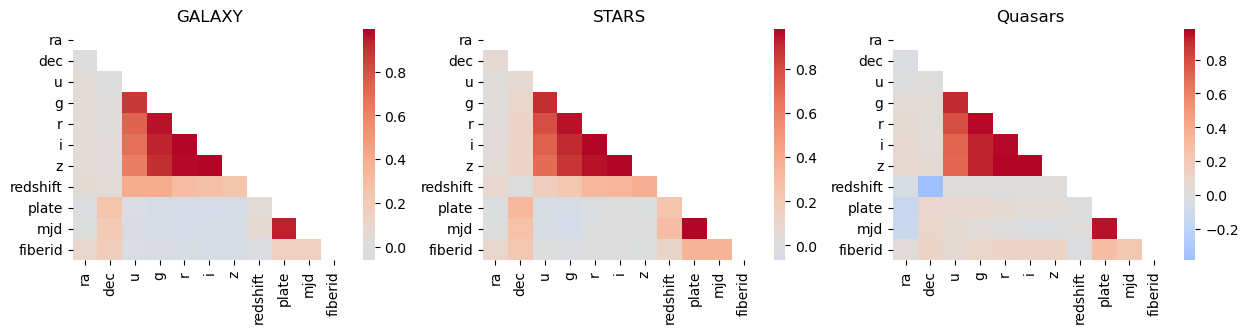

In [60]:
# make the same plot for Galaxies
plt.figure(figsize = (15,3),dpi = 100)
# "GALAXY" is label 0
plt.subplot(1,3,1)
galaxycorr= sdss_df[sdss_df['class']==0].drop('class',axis =1).corr();
sns.heatmap(galaxycorr,mask = np.triu(np.ones_like(galaxycorr, dtype=bool)),cmap = 'coolwarm',center = 0)
plt.title('GALAXY')
# Make the same plot for Stars (label 1)
plt.subplot(1,3,2)
starcorr= sdss_df[sdss_df['class']==1].drop('class',axis =1).corr();
sns.heatmap(starcorr,mask = np.triu(np.ones_like(galaxycorr, dtype=bool)),cmap = 'coolwarm',center = 0)
plt.title('STARS')
# make the same plots for quasars (label 2)
plt.subplot(1,3,3)
quacorr= sdss_df[sdss_df['class']==2].drop('class',axis =1).corr();
sns.heatmap(quacorr,mask = np.triu(np.ones_like(quacorr, dtype=bool)),cmap = 'coolwarm',center = 0)
plt.title('Quasars')

**Task: Can you comment on groups of observations that can be grouped together or that appear independent from each other given these correlations, and if there is any difference between the three celestial objects? (**1 point**)**

The five bands of telescope (u, g, r, i, z) and highly positive-correlated, I think they can be grouped together. Besides, "plate" and "mjd" are highly correlated too, they could group together as well.
The class "Galaxy" and class "Stars" have similar correlation pattern, while class "Quasars" are seen to be more independent.

### 1.5 Data exploration
Given the structure of the correlations, we will explore the values of the data.

#### 1.5.a. Distributions of redshift
"redshifting" happens when the source of light is becoming more distant to the receiver: the object is moving away from Earth. 

**Task: plot histograms for the 'redshift' feature column for each class (1 point).**

Text(0.5, 1.0, 'Quasars')

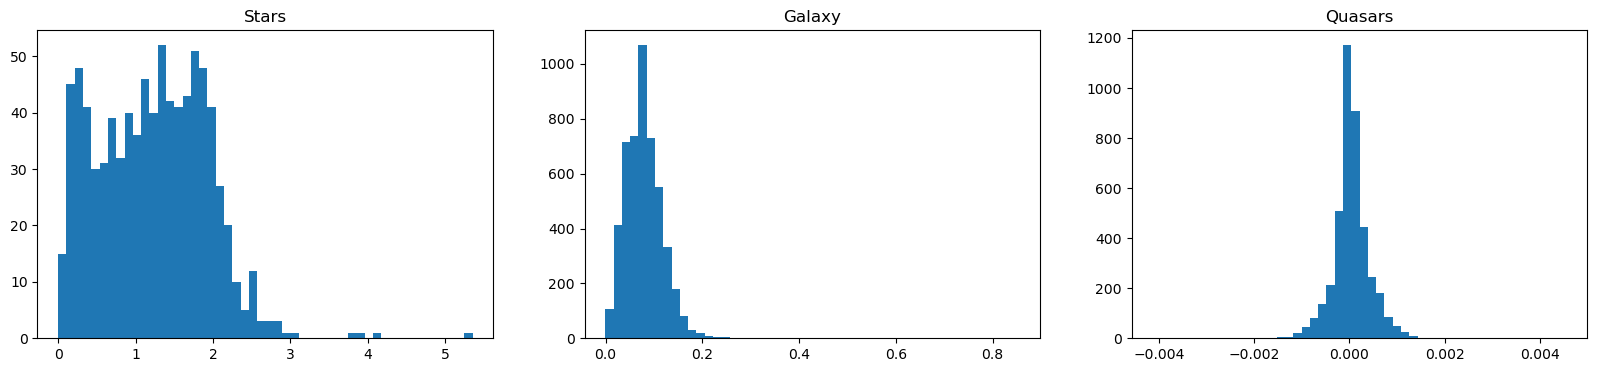

In [67]:
# answer
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 4))

axes[0].hist(sdss_df[sdss_df["class"] == 1].redshift, 50)
axes[0].set_title("Stars")

axes[1].hist(sdss_df[sdss_df["class"] == 0].redshift, 50)
axes[1].set_title("Galaxy")


axes[2].hist(sdss_df[sdss_df["class"] == 2].redshift, 50)
axes[2].set_title("Quasars")

**Task : Describe briefly the difference between the three histograms. (0.5 point)**

<!-- # answer -->
* **Star:** The histogram looks like a truncated zero-centered normal distribution. It looks like stars are both coming toward and away from the Earth.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075. It looks like galaxies are moving away from the Earth but at slow speeds.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers. This probably means that quasards are moving away from the earth with a diverse range of speeds.


#### 1.5.b. Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class. You can use the ``lmplot`` function in ``seaborn`` (https://seaborn.pydata.org/generated/seaborn.lmplot.html) to represent the sky view of these objects.

Text(0.5, 1.0, 'Equatorial coordinates')

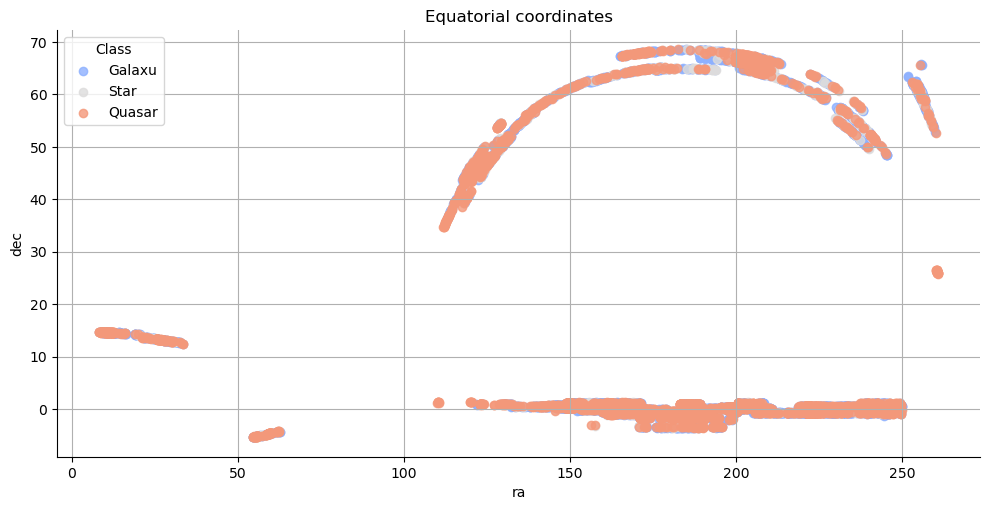

In [71]:

#sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', size=6, aspect=2,legend=False)
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm',aspect=2,legend=False)
plt.legend(title='Class', loc='upper left', labels=['Galaxu', 'Star','Quasar'])
plt.grid(True)
plt.title('Equatorial coordinates')

**Task: do you see any obvious differences such that one could easily discriminate between the two coordinates? (0.5 point)**

The ra axis  value is positive, while dec axis has both positive and negative value

In [ ]:
#### 1.5.c Filters - u,g,r,i,z 

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations. According to the correlation matrix, they are correlated for all three classes.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**Task Plot histograms and discuss why you expect these features to be correlated (1 points)**

(10.0, 22.0)

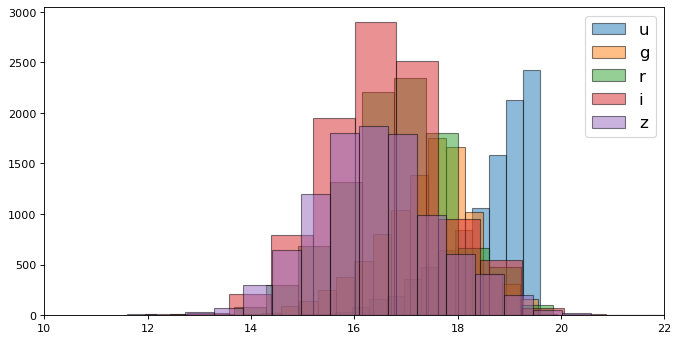

In [84]:
# Plot of histograms
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (10, 5), dpi = 80)
for x in ['u', 'g', 'r', 'i', 'z']:
    plt.hist(sdss_df[x], 20, edgecolor = 'k', alpha = 0.5, label = x)
plt.legend(fontsize = 15)
plt.xlim([10, 22])

<!-- Anwer: -->

### 1.6 Data Dimensionality Reduction
At this point, we are left with 8 features: redshift, u, g, r, i, z, ra, and dec. Among these, the filters (u, g, r, i, z) are correlated to each other. There is therefore a potential for reducing the dimensions of the features using PCA on these 5 features.

We will use the skilearn function ``sklearn.decomposition.PCA()`` to fit and transform the data into the PC coordinates. Lets' first explore how many PCs we need. Fit the PCA function over the total number of filters. You will fit the PCA function over an array with the columns selected from the dataframe. 

**Task: Perform the PCA over a max number of PCs, output the explained variance ratio values, decide on an appropriate maximum number of PC to use (6 points)**

In [85]:
# anwer
X = np.array(sdss_df[['u', 'g', 'r', 'i', 'z', 'ra', 'dec', 'redshift']])
pca = sklearn.decomposition.PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[7.80732146e-01 2.17355061e-01 1.68850343e-03 1.65451501e-04
 4.20150040e-05 7.66656428e-06 7.07689464e-06 2.07924632e-06]
[4778.12794467 2521.10899889  222.20699066   69.55720128   35.05168889
   14.97294174   14.38560426    7.79757777]


*Answer on how many PCs to use*



let's do 5 PCs

We will now re-perform PCA with the number of PCs you found is most appropriate. Re-apply the fit-transform function. Update the dataframe by adding the PCA value(s) and dropping the columns of the 5 filter features.

**Task: PCA again, fit and transform, update the dataframe with the new feature(s) (3 points)**

In [88]:
# answer
pca = sklearn.decomposition.PCA(n_components = 5)
pca.fit(X)
sdss_df = pd.concat([sdss_df, pd.DataFrame(pca.transform(X), columns=['PC1', "PC2", "PC3", "PC4", "PC5"])], axis = 1)


In [89]:
# answer
sdss_df

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid,PC1,PC2,PC3,PC4,PC5
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009,3306,54922,491,-7.959165,-14.775809,-1.452007,-1.369108,0.082279
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055,323,51615,541,-8.029157,-14.723183,-0.143869,-0.040920,-0.144762
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111,287,52023,513,-8.114188,-14.724403,1.354066,-0.596767,-0.007979
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111,3306,54922,510,-8.298438,-14.815806,-1.390470,0.562497,-0.091527
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590,3306,54922,512,-8.312614,-14.760037,-0.795188,1.270826,-0.302089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0,0.027583,447,51877,246,44.116205,36.820723,0.109765,-0.155787,-0.145722
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0,0.117772,447,51877,228,44.126072,36.952977,0.152268,0.401300,-0.079913
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,2,-0.000402,7303,57013,622,43.877038,36.954261,1.360994,0.348427,-0.338628
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0,0.014019,447,51877,229,43.952403,37.040094,1.273234,0.081873,-0.253182


## 2) Machine Learning Models (26 points)

We will now train different models on this dataset. We have a total of 8 features, 3 classes, and 10,000 samples. We will use K-Nearest Neighbors, Naive Bayes, Random Forest, Support Vector Machine, Multi Layer Perceptron.

We now follow a normal machine learning workflow:
* Feature scaling (2 points)
* Train/test set split (2 points)
* Model design, training, testing (15 points)
* Model comparisons, pick your winner, discuss feature importance using Random Forest. (10 points)

### 2.1 Feature Scaling
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster. You can scale the features only by dropping the "class" column without modifying the dataframe in place, using the pandas function ``drop()``.

**Task: Scale just the features (2 points)**

In [91]:
# answer
X = np.array(sdss_df[['u', 'g', 'r', 'i', 'z', 'ra', 'dec', 'redshift']])
Y = np.array(sdss_df['class'])
X -= np.min(X, axis = 0)
X /= np.max(X, axis = 0)

### 2.2 Test, train, validation data sets.
**Task: Split the data into a training and a test part.  (2 points)**

The models will be trained on the training data set and tested on the test data set

In [102]:
len(X)

10000

8000.0

In [112]:
# answer
idx_train = np.random.choice(np.arange(len(X)), int(0.7*len(X)), replace = False) # 70% percent for train 
idx_test = np.setdiff1d(np.arange(int(len(X))), idx_train) # 20% percent for test

X_train = X[idx_train, :]
Y_train = Y[idx_train]

X_test = X[idx_test, :]
Y_test = Y[idx_test]


Computation time is important to account for when scaling up the data set and the model size. You can evaluate the relative computational time using the function ``time.perf_counter()`` to evaluate the absolute time. Then compare the computational time by making the difference between two time stamps:

``t1=time.perf_counter()``

``t2=time.perf_counter()``

``tcomp = t2 - t1``

We will also assess the model performance of these multi-class classifiers. We will evaluate the average of the scores over the 3 class labels.

In [117]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
label_name = ['Star','Galaxy','Quasar']

In the following, we will be testing over several classifiers. Follow the steps:
1. model definition/design
2. training
3. prediction on test
4. evaluation: a) print the classification_report; b) save the precision, recall, fscore and accuracy in variables

### 2.3.a K Nearest Neighbors (3 points)
Check out the function arguments and definition here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [130]:
#answer
from sklearn.neighbors import KNeighborsClassifier
print("Classifying using K-nearest Neighbors")
t1 = time.perf_counter() # computation time
# model design
knc = KNeighborsClassifier()
# training
knc.fit(X_train, Y_train)

t2 = time.perf_counter()
print(t2 - t1) # the time difference
# evaluation on test

Y_predict = knc.predict(X_test)
# print the classification report
print("KNeighborsClassifier Accuracy:", metrics.accuracy_score(y_test_gnb, gnb_prediction))
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(Y_test, Y_predict)}\n")

Classifying using K-nearest Neighbors
0.009248683229088783
KNeighborsClassifier Accuracy: 0.9706060606060606
Classification report for classifier:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1522
           1       0.97      0.91      0.94       247
           2       0.84      0.88      0.86      1231

    accuracy                           0.88      3000
   macro avg       0.90      0.88      0.89      3000
weighted avg       0.88      0.88      0.88      3000




In [131]:
# save values of precision, recall, fscore, accuracy.

# initiate variables for 5 models
precision_all = np.zeros(5)
recall_all = np.zeros(5)
fscore_all = np.zeros(5)
accuracy_all = np.zeros(5)


# from sklearn.metrics import precision_score
# from sklearn.metrics import f1_score
precision_all[0] = metrics.precision_score(Y_test, Y_predict, average='weighted') # weighted-averaged for all class
recall_all[0] = metrics.recall_score(Y_test,Y_predict, average='weighted') 
fscore_all[0] = metrics.f1_score(Y_test, Y_predict, average='weighted') 
accuracy_all[0] = metrics.accuracy_score(y_true=Y_test ,y_pred=Y_predict)


### 2.3.b Naive Bayes (3 points)
Check out the sklearn tutorial pages here: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes. We propose to use the Gaussian Naive Bayes.

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. For this example then we will use the unscaled data, then rescale it.

In [132]:
# answer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
print("Classifying using Gaussian Naive Bayes")

# model design
gnb = GaussianNB()
scaler_gnb = MaxAbsScaler()
# re-scale the data
sdss = scaler_gnb.fit_transform(sdss_df.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df['class'], test_size=0.33)

t1 = time.perf_counter() # computation time
# training
gnb.fit(X_train_gnb, y_train_gnb)

# evaluation
gnb_prediction = gnb.predict(X_test_gnb)
t2=time.perf_counter()

print(t2-t1)
# evaluation: 
# print the classification report
print("Gaussian Naive Bayes Accuracy:", metrics.accuracy_score(y_test_gnb, gnb_prediction))
print(f"Classification report for classifier {gnb}:\n"
      f"{metrics.classification_report(y_test_gnb, gnb_prediction)}\n")
# save values of precision, recall, fscore, accuracy.
precision_all[1] = metrics.precision_score(y_test_gnb, gnb_prediction, average='weighted') # weighted-averaged for all class
recall_all[1] = metrics.recall_score(y_test_gnb, gnb_prediction, average='weighted') 
fscore_all[1] = metrics.f1_score(y_test_gnb, gnb_prediction, average='weighted') 
accuracy_all[1] = metrics.accuracy_score(y_test_gnb, gnb_prediction)


Classifying using Gaussian Naive Bayes
0.004921308718621731
Gaussian Naive Bayes Accuracy: 0.9684848484848485
Classification report for classifier GaussianNB():
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1663
           1       0.82      0.94      0.88       289
           2       0.99      0.97      0.98      1348

    accuracy                           0.97      3300
   macro avg       0.93      0.96      0.95      3300
weighted avg       0.97      0.97      0.97      3300




### 2.3.c Random Forest Classifier (2 points)
Check out the tutorial page here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [133]:
# answer
from sklearn.ensemble import RandomForestClassifier
print("Classifying using Random Forest Classifiers")


t1 = time.perf_counter() # computation time
# model design
rfc = RandomForestClassifier()

# training
rfc.fit(X_train, Y_train)

t2 = time.perf_counter()
print(t2 - t1)

# evaluation on test
Y_predict = rfc.predict(X_test)
# evaluation: 
# print the classification report
print("Random Forest Classifiers Accuracy:", metrics.accuracy_score(Y_test, Y_predict))
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(Y_test, Y_predict)}\n")
# save values of precision, recall, fscore, accuracy.
precision_all[2] = metrics.precision_score(Y_test, Y_predict, average='weighted') # weighted-averaged for all class
recall_all[2] = metrics.recall_score(Y_test,Y_predict, average='weighted') 
fscore_all[2] = metrics.f1_score(Y_test, Y_predict, average='weighted') 
accuracy_all[2] = metrics.accuracy_score(y_true=Y_test ,y_pred=Y_predict)



Classifying using Random Forest Classifiers
1.163652690127492
Random Forest Classifiers Accuracy: 0.9926666666666667
Classification report for classifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1522
           1       0.97      0.95      0.96       247
           2       1.00      1.00      1.00      1231

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000




### 2.3.d Support Vector Machine Classifier (2 points)
Check out the sklearn information page here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [137]:
# answer
from sklearn.svm import SVC
print("Classifying using Support Vector Machine Classfiers")

t1 = time.perf_counter() # computation time
# model design
svc = SVC()

# training
svc.fit(X_train, Y_train)

t2 = time.perf_counter()
print(t2 - t1)

# evaluation on test
Y_predict = rfc.predict(X_test)
# evaluation: 
# print the classification report
print("Support Vector Machine Classfiers Accuracy:", metrics.accuracy_score(Y_test, Y_predict))
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(Y_test, Y_predict)}\n")
# save values of precision, recall, fscore, accuracy.
precision_all[3] = metrics.precision_score(Y_test, Y_predict, average='weighted') # weighted-averaged for all class
recall_all[3] = metrics.recall_score(Y_test,Y_predict, average='weighted') 
fscore_all[3] = metrics.f1_score(Y_test, Y_predict, average='weighted') 
accuracy_all[3] = metrics.accuracy_score(y_true=Y_test ,y_pred=Y_predict)

Classifying using Support Vector Machine Classfiers
1.7437199084088206
Support Vector Machine Classfiers Accuracy: 0.9926666666666667
Classification report for classifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1522
           1       0.97      0.95      0.96       247
           2       1.00      1.00      1.00      1231

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000




### 2.3.e Multi-Layer Perceptron (3 points)

Check out the information page here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [138]:
# answer
from sklearn.neural_network import MLPClassifier
print("Classifying using Multi Layer Perceptron Classifier")

t1 = time.perf_counter() # computation time
# model design
mlp = MLPClassifier()

# training
mlp.fit(X_train, Y_train)

t2 = time.perf_counter()
print(t2 - t1)

# evaluation on test
Y_predict = rfc.predict(X_test)
# evaluation: 
# print the classification report
print("Multi Layer Perceptron Classifier Accuracy:", metrics.accuracy_score(Y_test, Y_predict))
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(Y_test, Y_predict)}\n")
# save values of precision, recall, fscore, accuracy.
precision_all[4] = metrics.precision_score(Y_test, Y_predict, average='weighted') # weighted-averaged for all class
recall_all[4] = metrics.recall_score(Y_test,Y_predict, average='weighted') 
fscore_all[4] = metrics.f1_score(Y_test, Y_predict, average='weighted') 
accuracy_all[4] = metrics.accuracy_score(y_true=Y_test ,y_pred=Y_predict)

Classifying using Multi Layer Perceptron Classifier
4.139482794329524
Multi Layer Perceptron Classifier Accuracy: 0.9926666666666667
Classification report for classifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1522
           1       0.97      0.95      0.96       247
           2       1.00      1.00      1.00      1231

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000




### 2.4 Model performance and comparison 

### 2.4.a Confusion Matrix and interpretation

**Task: Plot the confusion matrix (2 points)**

Use the sklearn function ``plot_confusion_matrix``. Find help here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html. We tested 5 models, make suplots, set the title on each subplots.


In [145]:
str(model.__class__).split(".")[-1].split("'")

['MLPClassifier', '>']

In [141]:
knc

KNeighborsClassifier()

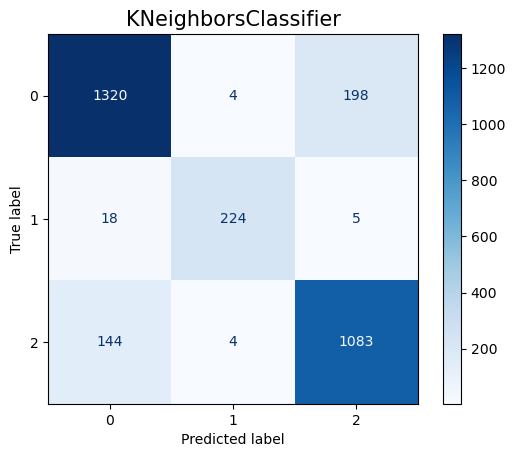

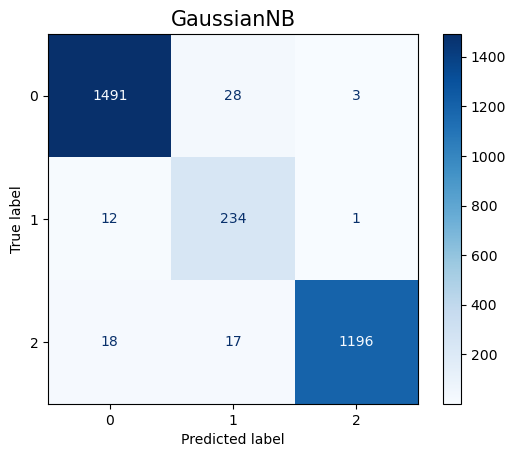

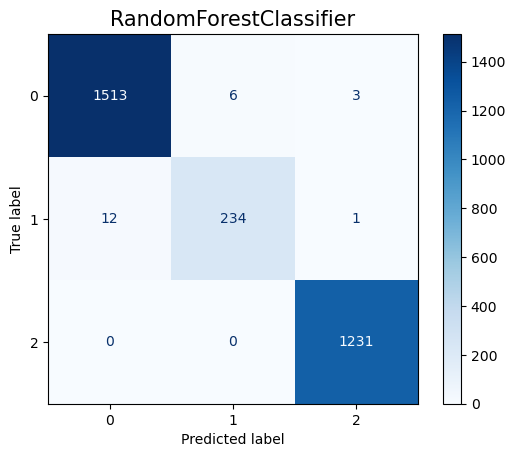

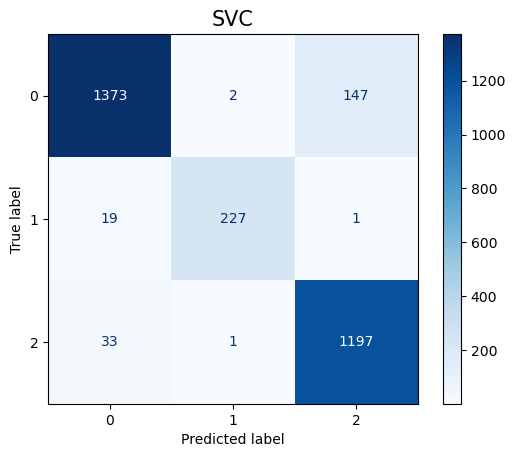

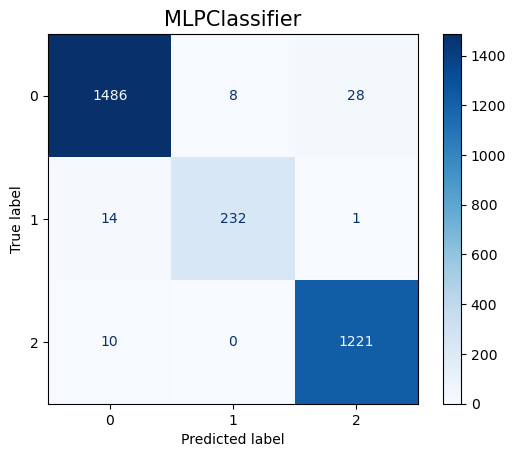

In [146]:
# plot the confusion matrix
for model in [knc, gnb, rfc, svc, mlp]:
    if model == gnb:
        X_test = sdss[idx_test, :]
        Y_test = Y[idx_test]
    else:
        X_test = X[idx_test, :]
        Y_test = Y[idx_test]
    plot_confusion_matrix(model, X_test, Y_test,cmap='Blues')
    plt.title(str(model.__class__).split(".")[-1].split("'")[0], fontsize = 15)


**Task: Comment on what you see the best classifier is likely to be (1 point).** You can also comment on the misclassification and confusion rates.

 The diagonal elemets are correctly classified, a good classifier shoule make the non-diagonal elements (misclassified) as small as possible.

### 2.4.a K Fold Cross Validation
We will now perform k fold cross valdiation for the classifiers. We use the function ``cross_val_score`` on each ewstimator, on the training set, with 10 folds, and use accuracy as a score metric.

**Task: perform the cross validation over K folds, output the mean and standard deviation of the accuracy (3 points)**

In [147]:
from sklearn.model_selection import cross_val_score
# print("K-nearest neighbors Mean:", scores_knn.mean(),"Standard Deviation:", scores_knn.std())
for model in [knc, gnb, rfc, svc, mlp]:
    print(f"Working on {model}")
    if model == gnb:
        X_data = sdss
    else:
        X_data = X
    scores_knn = cross_val_score(model, X_data, Y, cv = 10)
    
    print("K-nearest neighbors Mean: %.3f Standard Deviation:  %.3f" % (scores_knn.mean(), scores_knn.std()))


Working on KNeighborsClassifier()
K-nearest neighbors Mean: 0.866 Standard Deviation:  0.018
Working on GaussianNB()
K-nearest neighbors Mean: 0.968 Standard Deviation:  0.011
Working on RandomForestClassifier()
K-nearest neighbors Mean: 0.990 Standard Deviation:  0.003
Working on SVC()
K-nearest neighbors Mean: 0.931 Standard Deviation:  0.006
Working on MLPClassifier()
K-nearest neighbors Mean: 0.979 Standard Deviation:  0.006


**Task: Which method won the Xval test (1 point) ?**

see the cell below

<!-- answer here -->
Random Forest!!




### 2.4.c And the winner is ...

Let's compare the results. 
**Task: Create a pandas dataframe with all of the performance metrics, including the results from K-fold cross validation. (2 points)**

In [152]:
accuracy_all,

(array([0.87566667, 0.96848485, 0.99266667, 0.99266667, 0.99266667]),)

In [153]:
# create data frame
results = pd.DataFrame({
   'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVC','MLP'],
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'Fscore': fscore_all,
   'Kfold_accuracy_mean': [0.866,0.968,0.990,0.931,0.979],
   'Kfold_accuracy_std': [0.018,0.011,0.003,0.006,0.006]})

# sort values by the Fscore with the greatest value first.
results.sort_values(by=['Fscore'], ascending=False)


,Model,Accuracy,Precision,Recall,Fscore,Kfold_accuracy_mean,Kfold_accuracy_std
2,Random Forest,0.992667,0.992621,0.992667,0.992626,0.990,0.003
3,SVC,0.992667,0.992621,0.992667,0.992626,0.931,0.006
4,MLP,0.992667,0.992621,0.992667,0.992626,0.979,0.006
1,Naive Bayes,0.968485,0.970687,0.968485,0.969139,0.968,0.011
0,KNN,0.875667,0.876931,0.875667,0.875975,0.866,0.018


**Task: Comment on the accuracy and performance and choose a winner. (1 point)**

see the cell below

Random forest still the best one

<!-- answer here -->






## 3 Summary (4 points)

### 3.1 Feature Importance using Random Forest Classifier

Decision Trees have the unique property of being able to order features by their ability to split between the classes. If some features dominate over other in the predictive power of classes, one can further reduce the dimension of the features for additional analysis. The vector of feature importance is the module ``rfc.feature_importances_``, sorted with ascending importance. Store the vector of importance .

**Task: plot a bar plot using the function ``matplotlib.pyplot.bar``. (2 points)**

Text(0, 0.5, 'Importance')

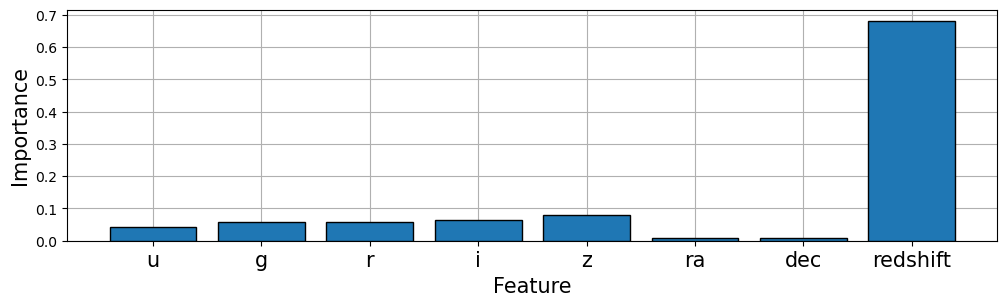

In [162]:
# answer
# vector of importance
# vector of features
plt.figure(figsize = (12, 3), dpi = 100)
plt.bar(np.arange(8), rfc.feature_importances_, edgecolor = 'k', zorder = 90)
plt.xticks(np.arange(8), ['u', 'g', 'r', 'i', 'z', 'ra', 'dec', 'redshift'], fontsize = 15);
plt.grid(True)
plt.xlabel("Feature", fontsize = 15)
plt.ylabel("Importance", fontsize = 15)




**Task: What are the top three features (1 point)?**

enter in the cell below

<!-- answer -->
redshift, z, and i

In this notebook, you have learned that redshift was the best predictor of what object you are observing. Now, did you actualy need to do this all to find this out? Probably not if you were an astrophysicist! But hey, we are not. So great job!

**Task: Briefly comment on what you have learned (1 point)**

see the cell below

I have learned many classifiers: K-Nearest Neighbour, Naive Bayes Classifier, Random Forest Classifier, SVC, and MLP. In addtion, the red shifts are the most important factor to distinguish galaxy, stars, and quasars.

## Bonus questions (5 points)


Perform hyperparameter tuning and ensemble learning to improve on the classification performance.

# answer below

Is random forest the best classification always?

<!-- answer -->